In [16]:
%reload_ext autoreload
%autoreload 2

import os
import sys
sys.path.append("..")
sys.path.append("../build_tf")
sys.path.append(os.environ['DH_DIR'])

from tqdm import tqdm
import pickle
import h5py

import numpy as np
from astropy.cosmology import Planck18
from astropy import units as u
from astropy import constants as const
# import jax
# import jax.numpy as jnp
# print(jax.devices())

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
mpl.rc_file('../matplotlibrc')

In [36]:
abscs['nBs'][6]

1.0

In [18]:
from dm21cm.utils import load_h5_dict
import dm21cm.physics as phys

from   darkhistory.spec.spectrum import Spectrum
import darkhistory.physics as dh_phys
import darkhistory.spec.spectools as spectools

In [17]:
from low_energy.lowE_electrons import make_interpolator
from low_energy.lowE_deposition import compute_fs

In [31]:
run_name = 'zf01'
tf_type = 'phot'
do_not_track_lowengphot = False
include_f_xray = True
xray_eng_range = (1e2, 1e4) # [eV]
use_tqdm = False
verbose = 0 # {0, 1}
stop_after_n = np.inf

In [32]:



#===== Load =====
data_dir = f"{os.environ['DM21CM_DATA_DIR']}/tf/{run_name}/{tf_type}"
save_dir = f"{os.environ['DM21CM_DATA_DIR']}/tf/{run_name}/{tf_type}"
os.makedirs(save_dir, exist_ok=True)

print('Loading tf: ', end=' ', flush=True)
hep_tfgv = np.load(f'{data_dir}/hep_tf_rxneo.npy')
print('hep', end=' ', flush=True)
lep_tfgv = np.load(f'{data_dir}/lep_tf_rxneo.npy')
print('lep', end=' ', flush=True)
lee_tfgv = np.load(f'{data_dir}/lee_tf_rxneo.npy')
print('lee', end=' ', flush=True)
hed_tfgv = np.load(f'{data_dir}/hed_tf_rxneo.npy')
print('hed', end=' ', flush=True)
cmbloss_gv = np.load(f'{data_dir}/cmbloss_rxneo.npy')
print('cmb', end=' ', flush=True)
dts = np.load(f'{data_dir}/dt_rxneo.npy')
print('dt',  end='.', flush=True)

Loading tf:  

hep lep lee hed cmb dt.

In [33]:
#===== Initialize =====
abscs = load_h5_dict(f"../data/abscissas/abscs_{run_name}.h5")
dlnz = abscs['dlnz']
inj_abscs = abscs['photE'] if tf_type == 'phot' else abscs['elecEk'] + dh_phys.me
i_xray_fm = np.searchsorted(abscs['photE'], xray_eng_range[0])
i_xray_to = np.searchsorted(abscs['photE'], xray_eng_range[1])
MEDEA_interp = make_interpolator(prefix='../data/MEDEA')

tfgv = np.zeros_like(hep_tfgv) # in: elec/phot, out: phot
depgv = np.zeros(
    hed_tfgv.shape[:-1] + (len(abscs['dep_c']),)
) # channels: {H ionization, He ionization, excitation, heat, continuum, xray}


#===== Loop =====
n_run = -1

for i_rs, rs in enumerate(abscs['rs']):
    if i_rs != 8:
        continue
    
    #===== Timestepping =====
    # We will always assume ionhist (IDL) uses the 21cmFAST's dt. This will be fixed in ionhist.
    dlnz = abscs['dlnz']
    zplusone_factor = np.exp(dlnz)
    dt = phys.dt_step(rs-1, zplusone_factor) # 21cmFAST dt
    # dt = dlnz / dh_phys.hubble(rs) # DH dt
    # dt = dts[i_rs, 1] # (rs, step) # IDL dt
    
    #===== Add cmbloss to highengphot =====
    cmb_un = spectools.discretize(abscs['photE'], dh_phys.CMB_spec, dh_phys.TCMB(rs))
    cmb_un_E = cmb_un.toteng()
    
    for i_x, x in enumerate(abscs['x']):
        if i_x != 3:
            continue
        for i_nBs, nBs in enumerate(abscs['nBs']):
            if i_nBs != 6:
                continue
            for i in range(len(inj_abscs)):
                cmb_E = cmbloss_gv[i_rs, i_x, i_nBs][i]# * dt # now [eV/Bavg]
                hep_tfgv[i_rs, i_x, i_nBs][i] += (-cmb_E/cmb_un_E) * cmb_un.N

            #===== Add lowengphot diagonal =====
            if tf_type == 'phot':
                for i in range(len(inj_abscs)):
                    if lep_tfgv[i_rs, i_x, i_nBs][i][i] > 1e-40:
                        break
                    lep_tfgv[i_rs, i_x, i_nBs][i][i] = 1.
            
            for i_injE, injE in enumerate(inj_abscs):
                
                assert n_run <= stop_after_n
                n_run += 1

                #===== Injection =====
                # inject one photon at i_injE
                
                hep_spec_N = hep_tfgv[i_rs, i_x, i_nBs, i_injE]
                lep_spec_N = lep_tfgv[i_rs, i_x, i_nBs, i_injE]
                lee_spec_N = lee_tfgv[i_rs, i_x, i_nBs, i_injE]
                hed_arr    = hed_tfgv[i_rs, i_x, i_nBs, i_injE]

                lowengelec_spec_at_rs = Spectrum(abscs['elecEk'], lee_spec_N, spec_type='N')
                lowengelec_spec_at_rs.rs = rs

                lowengphot_spec_at_rs = Spectrum(abscs['photE'], lep_spec_N, spec_type='N')
                lowengphot_spec_at_rs.rs = rs

                highengdep_at_rs = hed_arr / dt # [eV/Bavg/s]

                #===== Compute f's =====
                x_vec_for_f = np.array( [1-x, dh_phys.chi*(1-x), dh_phys.chi*x] ) # [HI, HeI, HeII]/nH
                nBs_ref = 1
                dE_dVdt_inj = injE * dh_phys.nB * nBs_ref * rs**3 / dt # [eV/cm^3 s]
                # in DH.main: (dN_inj/dB) / (dE_inj  /dVdt)
                # here:       (dN_inj   ) / (dE_injdB/dVdt)
                f_low, f_high = compute_fs(
                    MEDEA_interp=MEDEA_interp,
                    rs=rs,
                    x=x_vec_for_f,
                    elec_spec=lowengelec_spec_at_rs,
                    phot_spec=lowengphot_spec_at_rs,
                    dE_dVdt_inj=dE_dVdt_inj,
                    dt=dt,
                    highengdep=highengdep_at_rs,
                    cmbloss=0, # turned off in darkhistory main as well
                    method='no_He',
                    cross_check=False,
                    ion_old=False
                )
                f_raw = f_low + f_high

                #===== Compute tf & f values =====
                f_dep = f_raw
                if do_not_track_lowengphot:
                    phot_spec_N = hep_spec_N
                else:
                    i_exc_bin = np.searchsorted(spectools.get_bin_bound(abscs['photE']), 10.2) - 1 # 149
                    lep_prop_spec_N = lep_spec_N.copy()
                    lep_prop_spec_N[:i_exc_bin] *= 0.
                    f_lep_prop = np.dot(abscs['photE'], lep_prop_spec_N) / injE
                    phot_spec_N = hep_spec_N + lep_prop_spec_N
                    f_dep[4] -= f_lep_prop # adjust for the propagating lowengphot

                f_prop = np.dot(abscs['photE'], phot_spec_N) / injE
                f_tot = f_prop + np.sum(f_dep)

                #===== Fix energy conservation (known issues) =====
                if i_injE == 153: # issue at around 13.6 eV. Adjusting H_ion.
                    f_dep[0] += 1 - f_tot

                f_prop = np.dot(abscs['photE'], phot_spec_N) / injE
                f_tot = f_prop + np.sum(f_dep)

                #===== Energy conservation =====
                f_dep_str = ' '.join([f'{v:.3e}' for v in f_dep])
                print_str = f'{n_run} | {i_rs} {i_x} {i_nBs} {i_injE} | f_prop={f_prop:.6f} f_dep={f_dep_str} f_tot={f_tot:.6f}'
                energy_conservation_threshold = 1e-3
                if np.abs(f_tot - 1.) > energy_conservation_threshold:
                    print_str += f' | Energy error > {energy_conservation_threshold}'
                if verbose >= 1 or np.abs(f_tot - 1.) > energy_conservation_threshold:
                    print(print_str, flush=True)
                
                # enforce energy conservation
                phot_spec_N[i_injE] += 1 - f_tot # gives all extra energy to propagating photons
                
                #===== Dependent variables (Xray) =====
                if include_f_xray:
                    f_xray = np.dot(abscs['photE'][i_xray_fm:i_xray_to], phot_spec_N[i_xray_fm:i_xray_to]) / injE
                    if i_xray_fm <= i_injE and i_injE < i_xray_to:
                        f_xray -= phot_spec_N[i_injE] # ignore diagonal for now # NEED TO EXTRACT PROP
                    f_dep = np.append(f_dep, f_xray)

                #===== Populate transfer functions =====
                tfgv[i_rs, i_x, i_nBs, i_injE] = phot_spec_N
                depgv[i_rs, i_x, i_nBs, i_injE] = f_dep

/tmp/ipykernel_1433739/899074218.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(tfgv[8, 3, 6]), origin='lower')
/tmp/ipykernel_1433739/899074218.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(tfgv[8, 3, 6]), origin='lower')


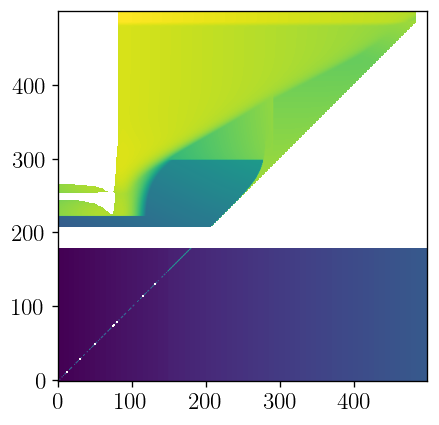

In [34]:
plt.imshow(np.log10(tfgv[8, 3, 6]), origin='lower')

/tmp/ipykernel_1433739/899074218.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(tfgv[8, 3, 6]), origin='lower')
/tmp/ipykernel_1433739/899074218.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(tfgv[8, 3, 6]), origin='lower')


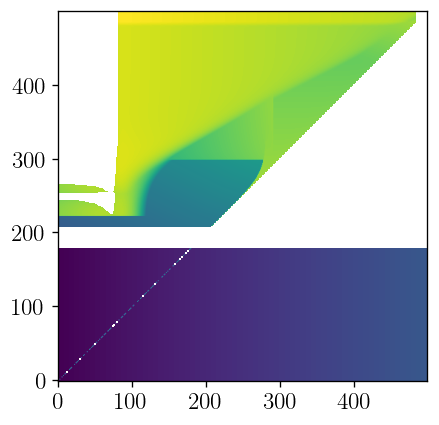

In [ ]:
plt.imshow(np.log10(tfgv[8, 3, 6]), origin='lower')

(1.4095642794511308e-58, 568.5982014704821)

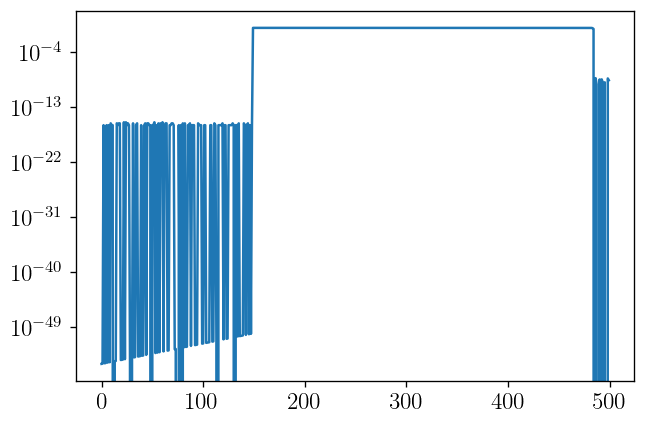

In [35]:
plt.plot(np.diag(tfgv[8, 3, 6]))
plt.yscale('log')
plt.ylim()

(1.4095812358856383e-58, 568.4545807962248)

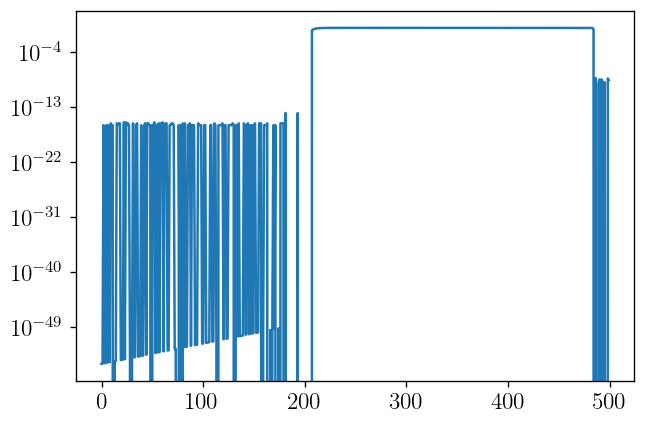

In [ ]:
plt.plot(np.diag(tfgv[8, 3, 6]))
plt.yscale('log')
plt.ylim()